# Notebook for Testing the Computation of CLVs

### Imports

In [37]:
######################
##	Library Imports
######################
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg as subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import jit

### Function Definitions

In [27]:
###########################
##	Function Definitions
###########################
def initial_conditions(dim, sys):

    x     = np.zeros((dim))
    x_ext = np.identity(dim)
    if sys == "Lorenz63":		
        x[0] = -1.01
        x[1] = 3.01
        x[2] = 2.01	
    elif sys == "Henon2D" or sys == "Lozi2D":
        x[0] = 0.5
        x[1] = 0.5
    elif sys == "Henon3D":
        x[0] = 0.5
        x[1] = 0.5
        x[2] = 0.5


    return x, x_ext

def RHS(x, x_ext, nexps, dim, sys):

    f = np.zeros((dim))

    if sys == "Lorenz63":
        f[0] = sigma * (x[1] - x[0])
        f[1] = x[0] * (rho - x[2]) - x[1]
        f[2] = x[0] * x[1] - beta * x[2]

        Jac = np.array([[-sigma, sigma, 0], [rho - x[2], -1, -x[0]], [x[1], x[0], -beta]])

        f_ext = np.matmul(Jac, x_ext)
    elif sys == "Henon2D":
        f[0] = 1 - a * (x[0]**2) + x[1]
        f[1] = b * x[0]

        Jac = np.array([[-2 * a * x[0], 1], [b, 0]])

        f_ext = np.matmul(Jac, x_ext)
    elif sys == "Lozi2D":
        f[0] = 1 - a * np.absolute(x[0]) + x[1]
        f[1] = b * x[0]

        Jac = np.array([[-a * np.sign(x[0]), 1], [b, 0]])

        f_ext = np.matmul(Jac, x_ext)
    elif sys == "Henon3D":
        f[0] = a - (x[1]**2) - b * x[2]
        f[1] = x[0] 
        f[2] = x[1]

        Jac = np.array([[0, -2*x[1], - b], [1, 0, 0], [0, 1, 0]])

        f_ext = np.matmul(Jac, x_ext)
    return f, f_ext

def jacobian(x, sys):
    
    Jac = np.zeros((x.shape, x.shape))

    if sys == "Lorenz63":
        Jac = np.array([[-sigma, sigma, 0], [rho - x[2], -1, -x[0]], [x[1], x[0], -beta]])

    return Jac

def compute_clvs(R_avg, T_avg, m_iter, dim, nexps):
	## Compute the CLVs by propagating backwards
	
	# Random Initial Conditions
	coeff_mat = np.triu(np.random.rand(dim, nexps))
	vec_norms = np.zeros((m_iter, nexps))
	CLVs      = np.zeros((dim, nexps, m_avg))
	angles    = np.zeros((m_iter, nexps))

	# Propogate backwards
	for m in range(m_iter):
		# Propegate 
		coeff_mat = np.linalg.solve(R_avg[:, :, -(m + 1)], coeff_mat)

		# Normalize
		for i in range(nexps):
			coeff_mat[:, i] = coeff_mat[:, i] / np.linalg.norm(coeff_mat[:, i])

		# Compute CLVs using coefficient matrix and GS basis vectors
		CLVs[:, :, -(m + 1)] = np.matmul(T_avg[:, :, -(m + 1)], coeff_mat)

		vec_norms[m, :] = np.linalg.norm(CLVs[:, :, m], axis = 0)

		# Compute angles
		indx = 0
		for n in range(nexps):
			exp = n + 1
			while exp < nexps:
				angles[-(m + 1), indx] = np.arccos(np.absolute(np.dot(CLVs[:, n, -(m + 1)], CLVs[:, exp, -(m + 1)])))
				exp  += 1
				indx += 1

		if m == m_iter - 1:
			print("Coeff:")
			print(coeff_mat[:, :])

	return angles, CLVs, vec_norms

def test_lorenz_angles(x, x_ext, m_end, m_trans, dim, sys):

	## Compute LCEs and forward propogation
	R_avg, T_avg = compute_lces(x, x_ext, m_end, m_trans, dim, sys)

	## Compute CLVs
	angles, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

	## Change rho 
	rho = 60

	## Compute LCEs and forward propogation
	R_avg, T_avg = compute_lces(x, x_ext, m_end, m_trans, dim, sys)

	## Compute CLVs
	angles_a, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

	## Plot distrubution of angles
	plt.figure()
	hist, bins  = np.histogram(angles, range = (0.0, np.pi / 2.0), bins = 900, density = True);
	bin_centers = (bins[1:] + bins[:-1]) * 0.5
	plt.plot(bin_centers, hist)
	hist, bins  = np.histogram(angles_a, range = (0.0, np.pi / 2.0), bins = 900, density = True);
	bin_centers = (bins[1:] + bins[:-1]) * 0.5
	plt.plot(bin_centers, hist)
	plt.xlim(0.0, np.pi/2.0)
	# plt.ylim(0.0, 5.0)
	plt.xlabel(r"$\theta$")
	plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
	plt.legend([r"$\rho = 28$", r"$\rho = 60$"])
	plt.ylabel(r"PDF")
	plt.title(r"Distribution of Angles Between Intrinsic Stable and Unstable Directions")
	plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions" + "/AnglesDistribution.pdf")  
	plt.close()


def test_henonlozi_angles(x, x_ext, m_end, m_trans, dim, sys):

	## Compute LCEs and forward propogation
	R_avg, T_avg = compute_lces(x, x_ext, m_end, m_trans, dim, sys)

	## Compute CLVs
	angles, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

	## Change system
	sys = "Lozi2D"

	## Compute LCEs and forward propogation
	R_avg, T_avg = compute_lces(x, x_ext, m_end, m_trans, dim, sys)

	## Compute CLVs
	angles_a, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

	## Plot distrubution of angles
	plt.figure()
	hist, bins  = np.histogram(angles, range = (0.0, np.pi / 2.0), bins = 900, density = True);
	bin_centers = (bins[1:] + bins[:-1]) * 0.5
	plt.plot(bin_centers, hist)
	hist, bins  = np.histogram(angles_a, range = (0.0, np.pi / 2.0), bins = 900, density = True);
	bin_centers = (bins[1:] + bins[:-1]) * 0.5
	plt.plot(bin_centers, hist / 10)   # Reduced by a factor of 10 for visual purposes
	plt.xlim(0.0, np.pi/2.0)
	# plt.ylim(0.0, 5.0)
	plt.xlabel(r"$\theta$")
	plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
	plt.legend([r"Henon Map", r"Lozi Map"])
	plt.ylabel(r"PDF")
	plt.title(r"Distribution of Angles Between Intrinsic Stable and Unstable Directions")
	plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions" + "/AnglesDistribution.pdf")  
	plt.close()


def compute_lces(x, x_ext, m_end, m_trans, dim, sys):	
	lce     = np.zeros((nexps)) 
	run_sum = np.zeros((nexps))

	R_avg = np.zeros((dim, nexps, m_avg))
	T_avg = np.zeros((dim, nexps, m_avg))
	lce_out = np.zeros((m_avg, nexps))

	x_out     = np.zeros((m_end, nexps))
	x_ext_out = np.zeros((dim, nexps, m_avg))

	m     = 1
	iters = 1
	while m < m_end:


		for i in range(m_iters):

			if sys == "Henon2D" or sys == "Lozi2D" or sys == "Henon3D":
				x, x_ext = RHS(x, x_ext, nexps, dim, sys)
			else:
				## Stages
				RK1, RK1_ext = RHS(x, x_ext, nexps, dim, sys)
				RK2, RK2_ext = RHS(x + (dt / 2) * RK1, x_ext + (dt / 2) * RK1_ext, nexps, dim, sys)
				RK3, RK3_ext = RHS(x + (dt / 2) * RK2, x_ext + (dt / 2) * RK2_ext, nexps, dim, sys)
				RK4, RK4_ext = RHS(x + dt * RK3, x_ext + dt * RK3_ext, nexps, dim, sys)

				## Update
				x = x + (dt / 6) * (RK1 + 2 * RK2 + 2 * RK3 + RK4)
				x_ext = x_ext + (dt / 6) * (RK1_ext + 2 * RK2_ext + 2 * RK3_ext + RK4_ext)


			iters += 1
			t = iters * dt


		Q, R = np.linalg.qr(x_ext)

		diags = np.diag(R)

		rnorm = np.absolute(diags)
		x_ext = Q
		# x_ext = np.matmul(Q, np.diag(np.sign(diags)))
		
		x_out[m, :] = x
		# x_ext_out[:, :, m] = x_ext

		if m >= m_trans:

			## Store the R and Tangent matrices
			R_avg[:, :, m - m_trans] = R
			T_avg[:, :, m - m_trans] = x_ext

			for n in range(nexps):
				run_sum[n] = run_sum[n] + np.log(rnorm[n])
				lce[n]     = run_sum[n] / (t - m_trans * dt)
				lce_out[m - m_trans, n] = lce[n]
			
			if np.mod(m, 1) == 0:
				lce_sum = 0.0
				dim_k   = 0
				for n in range(nexps):
					if lce_sum + lce[n] >= 0:
						lce_sum += lce[n]
						dim_k   += 1
					else:
						break
				# print("Iter: {} | t = {:0.02f} / {} | Sum: {:5.6f} | Dim: {:5.6f}".format(m, t, m_iters * m_end, np.sum(lce), dim_k + (lce_sum / np.absolute(lce[dim_k]))))
				# print("h = {}".format(lce))

		m += 1

	return R_avg, T_avg, lce_out, x_out
###########################
##	Function Definitions
###########################
def initial_conditions(dim, sys):

	x     = np.zeros((dim))
	x_ext = np.identity(dim)
	if sys == "Lorenz63":		
		x[0] = -1.01
		x[1] = 3.01
		x[2] = 2.01	
	elif sys == "Henon2D" or sys == "Lozi2D":
		x[0] = 0.5
		x[1] = 0.5
	elif sys == "Henon3D":
		x[0] = 0.5
		x[1] = 0.5
		x[2] = 0.5


	return x, x_ext

def RHS(x, x_ext, nexps, dim, sys):

	f = np.zeros((dim))

	if sys == "Lorenz63":
		f[0] = sigma * (x[1] - x[0])
		f[1] = x[0] * (rho - x[2]) - x[1]
		f[2] = x[0] * x[1] - beta * x[2]

		Jac = np.array([[-sigma, sigma, 0], [rho - x[2], -1, -x[0]], [x[1], x[0], -beta]])

		f_ext = np.matmul(Jac, x_ext)
	elif sys == "Henon2D":
		f[0] = 1 - a * (x[0]**2) + x[1]
		f[1] = b * x[0]

		Jac = np.array([[-2 * a * x[0], 1], [b, 0]])

		f_ext = np.matmul(Jac, x_ext)
	elif sys == "Lozi2D":
		f[0] = 1 - a * np.absolute(x[0]) + x[1]
		f[1] = b * x[0]

		Jac = np.array([[-a * np.sign(x[0]), 1], [b, 0]])

		f_ext = np.matmul(Jac, x_ext)
	elif sys == "Henon3D":
		f[0] = a - (x[1]**2) - b * x[2]
		f[1] = x[0] 
		f[2] = x[1]

		Jac = np.array([[0, -2*x[1], - b], [1, 0, 0], [0, 1, 0]])

		f_ext = np.matmul(Jac, x_ext)
	return f, f_ext

def jacobian(x, sys):

	if sys == "Lorenz63":
		Jac = np.array([[-sigma, sigma, 0], [rho - x[2], -1, -x[0]], [x[1], x[0], -beta]])

	return Jac

def compute_clvs(R_avg, T_avg, m_iter, dim, nexps):
	## Compute the CLVs by propagating backwards
	
	# Random Initial Conditions
	coeff_mat = np.triu(np.random.rand(dim, nexps))
	vec_norms = np.zeros((m_iter, nexps))
	CLVs      = np.zeros((dim, nexps, m_avg))
	angles    = np.zeros((m_iter, nexps))

	# Propogate backwards
	for m in range(m_iter):
		# Propegate 
		coeff_mat = np.linalg.solve(R_avg[:, :, -(m + 1)], coeff_mat)

		# Normalize
		for i in range(nexps):
			coeff_mat[:, i] = coeff_mat[:, i] / np.linalg.norm(coeff_mat[:, i])

		# Compute CLVs using coefficient matrix and GS basis vectors
		CLVs[:, :, -(m + 1)] = np.matmul(T_avg[:, :, -(m + 1)], coeff_mat)

		vec_norms[m, :] = np.linalg.norm(CLVs[:, :, m], axis = 0)

		# Compute angles
		indx = 0
		for n in range(nexps):
			exp = n + 1
			while exp < nexps:
				angles[-(m + 1), indx] = np.arccos(np.absolute(np.dot(CLVs[:, n, -(m + 1)], CLVs[:, exp, -(m + 1)])))
				exp  += 1
				indx += 1

		if m == m_iter - 1:
			print("Coeff:")
			print(coeff_mat[:, :])

	return angles, CLVs, vec_norms

def test_lorenz_angles(x, x_ext, m_end, m_trans, dim, sys):

	## Compute LCEs and forward propogation
	R_avg, T_avg = compute_lces(x, x_ext, m_end, m_trans, dim, sys)

	## Compute CLVs
	angles, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

	## Change rho 
	rho = 60

	## Compute LCEs and forward propogation
	R_avg, T_avg = compute_lces(x, x_ext, m_end, m_trans, dim, sys)

	## Compute CLVs
	angles_a, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

	## Plot distrubution of angles
	plt.figure()
	hist, bins  = np.histogram(angles, range = (0.0, np.pi / 2.0), bins = 900, density = True);
	bin_centers = (bins[1:] + bins[:-1]) * 0.5
	plt.plot(bin_centers, hist)
	hist, bins  = np.histogram(angles_a, range = (0.0, np.pi / 2.0), bins = 900, density = True);
	bin_centers = (bins[1:] + bins[:-1]) * 0.5
	plt.plot(bin_centers, hist)
	plt.xlim(0.0, np.pi/2.0)
	# plt.ylim(0.0, 5.0)
	plt.xlabel(r"$\theta$")
	plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
	plt.legend([r"$\rho = 28$", r"$\rho = 60$"])
	plt.ylabel(r"PDF")
	plt.title(r"Distribution of Angles Between Intrinsic Stable and Unstable Directions")
	plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions" + "/AnglesDistribution.pdf")  
	plt.close()


def test_henonlozi_angles(x, x_ext, m_end, m_trans, dim, sys):

	## Compute LCEs and forward propogation
	R_avg, T_avg = compute_lces(x, x_ext, m_end, m_trans, dim, sys)

	## Compute CLVs
	angles, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

	## Change system
	sys = "Lozi2D"

	## Compute LCEs and forward propogation
	R_avg, T_avg = compute_lces(x, x_ext, m_end, m_trans, dim, sys)

	## Compute CLVs
	angles_a, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

	## Plot distrubution of angles
	plt.figure()
	hist, bins  = np.histogram(angles, range = (0.0, np.pi / 2.0), bins = 900, density = True);
	bin_centers = (bins[1:] + bins[:-1]) * 0.5
	plt.plot(bin_centers, hist)
	hist, bins  = np.histogram(angles_a, range = (0.0, np.pi / 2.0), bins = 900, density = True);
	bin_centers = (bins[1:] + bins[:-1]) * 0.5
	plt.plot(bin_centers, hist / 10)   # Reduced by a factor of 10 for visual purposes
	plt.xlim(0.0, np.pi/2.0)
	# plt.ylim(0.0, 5.0)
	plt.xlabel(r"$\theta$")
	plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
	plt.legend([r"Henon Map", r"Lozi Map"])
	plt.ylabel(r"PDF")
	plt.title(r"Distribution of Angles Between Intrinsic Stable and Unstable Directions")
	plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions" + "/AnglesDistribution.pdf")  
	plt.close()


def compute_lces(x, x_ext, m_end, m_trans, dim, sys):	
	lce     = np.zeros((nexps)) 
	run_sum = np.zeros((nexps))

	R_avg = np.zeros((dim, nexps, m_avg))
	T_avg = np.zeros((dim, nexps, m_avg))
	lce_out = np.zeros((m_avg, nexps))

	x_out     = np.zeros((m_end, nexps))
	x_ext_out = np.zeros((dim, nexps, m_avg))

	m     = 1
	iters = 1
	while m < m_end:


		for i in range(m_iters):

			if sys == "Henon2D" or sys == "Lozi2D" or sys == "Henon3D":
				x, x_ext = RHS(x, x_ext, nexps, dim, sys)
			else:
				## Stages
				RK1, RK1_ext = RHS(x, x_ext, nexps, dim, sys)
				RK2, RK2_ext = RHS(x + (dt / 2) * RK1, x_ext + (dt / 2) * RK1_ext, nexps, dim, sys)
				RK3, RK3_ext = RHS(x + (dt / 2) * RK2, x_ext + (dt / 2) * RK2_ext, nexps, dim, sys)
				RK4, RK4_ext = RHS(x + dt * RK3, x_ext + dt * RK3_ext, nexps, dim, sys)

				## Update
				x = x + (dt / 6) * (RK1 + 2 * RK2 + 2 * RK3 + RK4)
				x_ext = x_ext + (dt / 6) * (RK1_ext + 2 * RK2_ext + 2 * RK3_ext + RK4_ext)


			iters += 1
			t = iters * dt


		Q, R = np.linalg.qr(x_ext)

		diags = np.diag(R)

		rnorm = np.absolute(diags)
		x_ext = Q
		# x_ext = np.matmul(Q, np.diag(np.sign(diags)))
		
		x_out[m, :] = x
		# x_ext_out[:, :, m] = x_ext

		if m >= m_trans:

			## Store the R and Tangent matrices
			R_avg[:, :, m - m_trans] = R
			T_avg[:, :, m - m_trans] = x_ext

			for n in range(nexps):
				run_sum[n] = run_sum[n] + np.log(rnorm[n])
				lce[n]     = run_sum[n] / (t - m_trans * dt)
				lce_out[m - m_trans, n] = lce[n]
			
			if np.mod(m, 1) == 0:
				lce_sum = 0.0
				dim_k   = 0
				for n in range(nexps):
					if lce_sum + lce[n] >= 0:
						lce_sum += lce[n]
						dim_k   += 1
					else:
						break
				# print("Iter: {} | t = {:0.02f} / {} | Sum: {:5.6f} | Dim: {:5.6f}".format(m, t, m_iters * m_end, np.sum(lce), dim_k + (lce_sum / np.absolute(lce[dim_k]))))
				# print("h = {}".format(lce))

		m += 1

	return R_avg, T_avg, lce_out, x_out


## Main Programme

### Setup

In [56]:
## Select systems
sys = "Lorenz63"
# sys = "Henon2D"
# sys = "Lozi2D"
# sys = "Henon3D"

## Select Iteration variables
m_trans = 100000
m_avg   = 100000
m_end   = m_avg + m_trans
m_iters = 10

## System parameters
if sys == "Lorenz63":
    m_trans = 1000
    m_avg   = 1000000
    m_end   = m_avg + m_trans
    m_iters = 1

    sigma = 10
    rho   = 28
    beta  = 8/3
    dim   = 3
    nexps = dim
    t0    = 0.0
    t     = t0
    dt    = 0.01
    T     = dt * m_iters 

    ## Get initial conditions
    x, x_ext = initial_conditions(dim, sys)

    # test_lorenz_angles(x, x_ext, m_end, m_trans, dim, sys)

elif sys == "Henon2D":
    a     = 1.4
    b     = 0.3
    dim   = 2
    nexps = dim
    t0    = 0
    t     = t0
    dt    = 1
    T     = dt * m_iters 

    ## Get initial conditions
    x, x_ext = initial_conditions(dim, sys)

    test_henonlozi_angles(x, x_ext, m_end, m_trans, dim, sys)
elif sys == "Lozi2D":
    a     = 1.4
    b     = 0.3
    dim   = 2
    nexps = dim
    t0    = 0
    t     = t0
    dt    = 1
    T     = dt * m_iters
elif sys == "Henon3D":
    a     = 1.76
    b     = 0.1
    dim   = 3
    nexps = dim
    t0    = 0
    t     = t0
    dt    = 1
    T     = dt * m_iters 

    ## Get initial conditions
    x, x_ext = initial_conditions(dim, sys)

### Compute Forward Dynamics - LCEs, Tangent Space Evolution, R matrix etc

In [57]:
## Compute LCEs and forward propogation
R_avg, T_avg, lce, x_out = compute_lces(x, x_ext, m_end, m_trans, dim, sys)


### Compute Backward Dynamics - Evolve the Coefficient matrix C backwards to Compute the CLVs

In [58]:
## Compute CLVs
angles, CLVs, vec_norms = compute_clvs(R_avg, T_avg, m_end - m_trans, dim, nexps)

Coeff:
[[-1.          0.55650123 -0.35138886]
 [ 0.         -0.83084679  0.37347667]
 [ 0.          0.          0.85851095]]


# Check if Correct

In [31]:
w = 0

print("CLV_0")
print(CLVs[:, :, w])

print("LCE")
print(lce[w, :])

print("Forward")
jacob   = jacobian(x_out[m_trans + w, :], sys)
vn      = np.matmul(jacob, CLVs[:, :, w])
vn_norm = np.linalg.norm(vn, axis = 0)
print(vn)
print(np.log(vn_norm))
print("CLV_1 * lamda")
print(CLVs[:, :, w + 1])


# print("G_0:")
print(T_avg[:, :, w])

# print("CLVs_0:")
# print(CLVs[:, :, w])

# print("Lyap Exps:")
# print(lce[-1, :])

# print("CLV norms:")
# print(np.sum(vec_norms[:, :], axis = 0))
# print(np.sum(vec_norms[:, :], axis = 0) / ((m_end - m_trans) * dt))


CLV_0
[[-0.5994438  -0.5708883   0.99227902]
 [-0.69180613 -0.2257087  -0.12097723]
 [-0.40258094 -0.78939352  0.02732868]]
LCE
[-1.46639922 -2.69880043 -9.50146702]
Forward
[[ -0.92362329   3.45179598 -11.13256252]
 [  5.25321615   7.21764738  -3.2616931 ]
 [ -4.00674206   0.09166664   0.07904103]]
[1.89778214 2.07958005 2.45107509]
CLV_1 * lamda
[[-0.60033858 -0.57020661  0.99199526]
 [-0.6896914  -0.22252778 -0.12324225]
 [-0.40486956 -0.79078809  0.02750905]]
[[-0.5994438   0.14130118 -0.78784587]
 [-0.69180613 -0.58652794  0.42117604]
 [-0.40258094  0.79750796  0.44934356]]


### Plot Attractor and Angles between Submanifolds

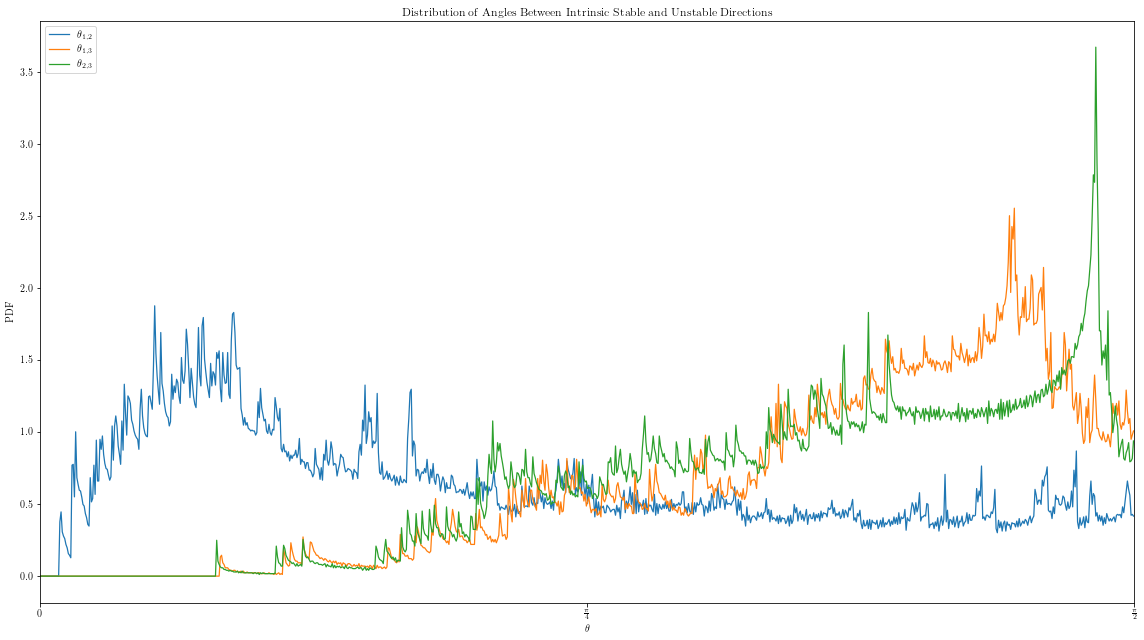

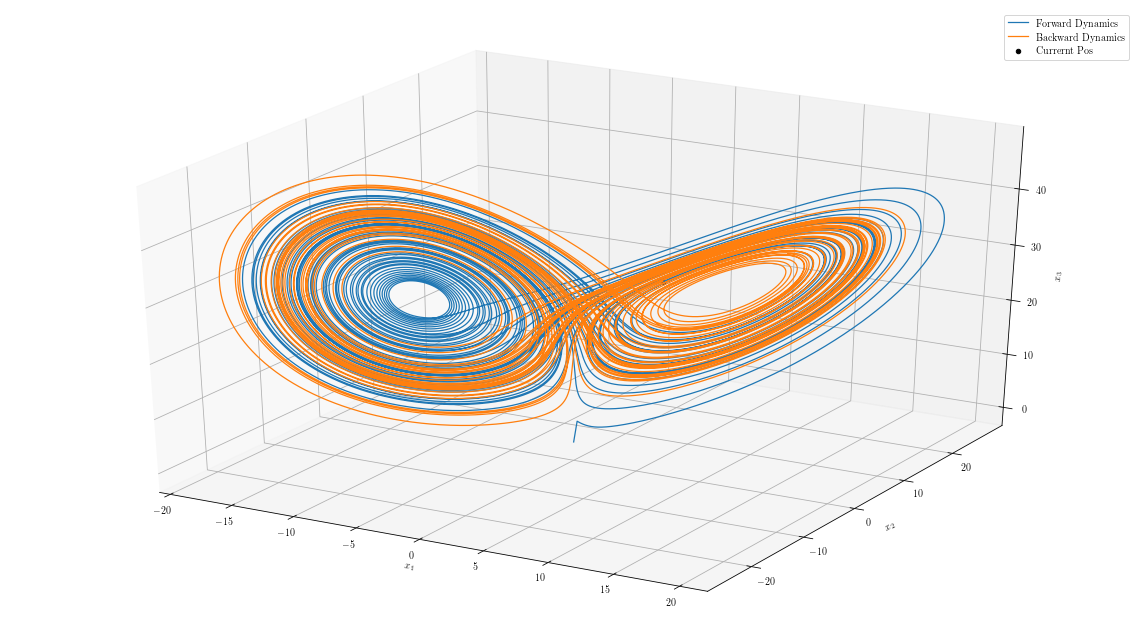

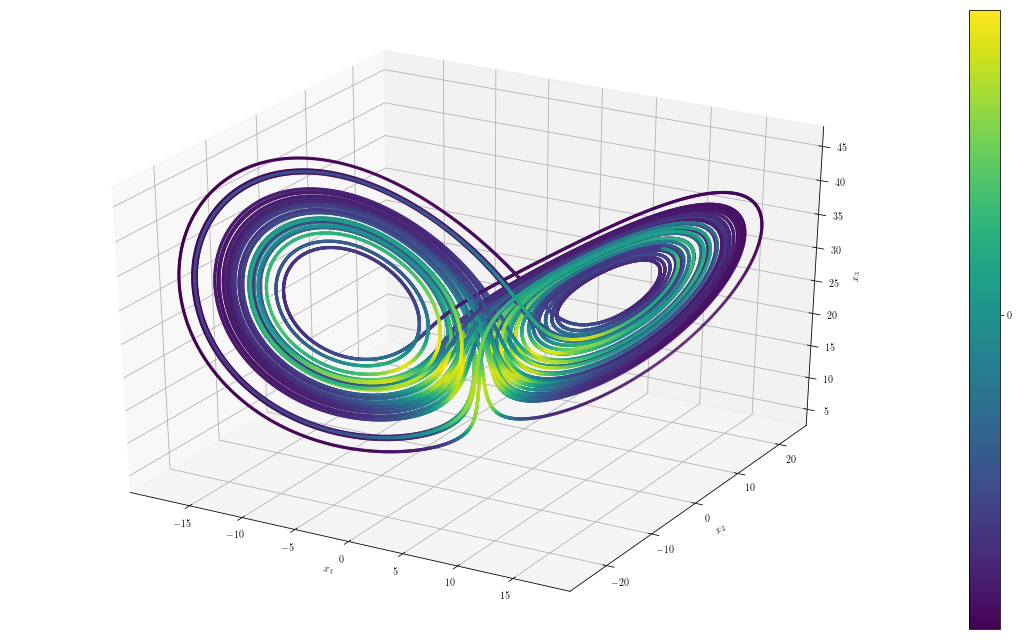

In [32]:
## Plot distrubution of angles
plt.figure()
hist, bins  = np.histogram(angles[:-1000, 0], range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
hist, bins  = np.histogram(angles[:-1000, 1], range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
hist, bins  = np.histogram(angles[:-1000, 2], range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 2}$", r"$\theta_{1,3}$", r"$\theta_{2,3}$"])
plt.ylabel(r"PDF")
plt.title(r"Distribution of Angles Between Intrinsic Stable and Unstable Directions")
# plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/AnglesDistribution_Lorenz.pdf")  
# plt.close()
plt.show()

if sys == "Henon3D":
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p  = ax.scatter(x_out[:, 0], x_out[:, 1], x_out[:, 2], marker = '.', c = np.amin(angles[:, :], axis = 1), cmap = cm.viridis)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$x_3$")
    fig.colorbar(p)
#     plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/Attractor_Henon3D.pdf")  
#     plt.close()
    plt.show()
elif sys == "Lorenz63":
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot3D(x_out[:m_trans, 0], x_out[:m_trans, 1], x_out[:m_trans, 2], zorder = 1)
    ax.plot3D(x_out[m_trans:, 0], x_out[m_trans:, 1], x_out[m_trans:, 2], zorder = 2)
    ax.scatter(x_out[m_trans - 1, 0], x_out[m_trans - 1, 1], x_out[m_trans - 1, 2], marker = "o", c = "black", zorder = 10)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$x_3$")
    ax.legend([r"Forward Dynamics", r"Backward Dynamics", r"Currernt Pos"])
#     plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/Attractor_Lorenz_1.pdf")  
    # plt.close()
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p  = ax.scatter(x_out[m_trans:, 0], x_out[m_trans:, 1], x_out[m_trans:, 2], marker = '.', c = np.amin(angles[:, :], axis = 1), cmap = cm.viridis)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.set_zlabel(r"$x_3$")
    cbar  = plt.colorbar(p)
    cbar.set_ticks([0.0, np.pi / 4.0, np.pi/2.0])
    cbar.set_ticklabels([r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
    # cbar.set_label(r"$\theta$")
#     plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/Attractor_Lorenz.pdf")  
#     plt.close()
    plt.show()

In [ ]:
theta1 = np.zeros((CLVs.shape[2]))
theta2 = np.zeros((CLVs.shape[2]))
for i in range(CLVs.shape[2]):
    # theta1
    subspaceA = CLVs[:, 0, i].reshape(3, 1)
    subspaceB = CLVs[:, 1:, i].reshape(3, 2)    
    theta1[i] = subspace_angles(subspaceA, subspaceB)
    
    # theta2
    subspaceA = CLVs[:, :2, i].reshape(3, 2)
    subspaceB = CLVs[:, 2, i].reshape(3, 1)    
    theta2[i] = subspace_angles(subspaceA, subspaceB)


In [ ]:
plt.figure()
hist, bins  = np.histogram(theta1, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
hist, bins  = np.histogram(theta2, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 2}$", r"$\theta_{1,3}$", r"$\theta_{2,3}$"])
plt.ylabel(r"PDF")
plt.yscale("log")
plt.legend([r"$\theta_1$", r"$\theta_2$"])
plt.title(r"Distribution of Angles Between Tangent Subspaces")
plt.show()